# Локализация. Упражнения

В этих упражнениях вам предлагается реализовать простые алгоритмы локализации роботов. На лекции, помимо фильтра частиц, были упомянуты методы триангуляции и альфа-бета фильтр. Давайте их реализуем: обе реализации должны быть сделаны в виде класса, у которого должен быть метод update. Метод update принимает на вход измеренения с камеры о положении ориентиров в сосбтвенной системе координат робота.

В качестве ориентиров будем использовать координаты стоек ворот. Для удобства будем пользоваться упрощенным вариантом, при котором ворота разных цветов. В словаре храняться положения стоек в глобальной системе координат (точка (0, 0) нахождится в центре поля)

In [2]:
landmarks = {
    "blue_posts": [
        [ -4.5, -1.0], [ -4.5, 1.0]
    ],
    "yellow_posts":[
        [ 4.5, -1.0], [ 4.5, 1.0]
    ]
}

Пример данных, которые могут поступать в модуль на одном шаге всей системы. Данные во втором словаре – это данные одометрии с собвственной информацией робота о перемещении за один шаг системы. Для проверки работы придумайте и запишите набор данных с такой же структурой. 

In [3]:
observations = {"yellow_posts":[[4.45, -0.99],[4.49, 1.09]], "blue_posts":[]}
shift = {'shift_x':0.0, 'shift_y':0.01, 'shift_angle':-0.4}

In [4]:
import sys
import json
import math
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../localization/")

from robot import Robot
from field import Field

with open("../localization/landmarks.json", "r") as f:
            landmarks = json.loads(f.read())


### 1) Реализовать локализацию триангуляцией (3 балл)
    

In [12]:
def find_coord(observations, landmarks):
    obs = np.array(observations['yellow_posts'])
    lm = np.array(landmarks['yellow_posts'])
    lm1 = lm[0, :]
    lm2 = lm[1, :]
    r1 = np.array([obs[0, 0],
                  obs[0, 1]])
    r2 = np.array([obs[0, 0],
                  obs[0, 1]])
    dist_1 = np.linalg.norm(r1, ord=2)
    dist_2 = np.linalg.norm(r2, ord=2)

    alpha = np.square(dist_1) - np.square(dist_2) 
    alpha += np.square(lm2[0]) - np.square(lm1[0])
    alpha += np.square(lm2[1] - lm1[1])
    alpha /= 2 * (lm2[1] - lm1[1])
    beta = (lm1[0] - lm2[0]) / (lm2[1] - lm1[1])

    a = 1 + np.square(beta)
    b = -2*lm1[0] + 2 * alpha * beta 
    c = np.square(lm1[0]) + np.square(alpha) - np.square(dist_1)
    Hypoths_x = np.roots((a, b, c))
    Hypoths_x = np.array([x.real for x in Hypoths_x])
    Hypoths_y = lm1[1] + alpha + beta * Hypoths_x

    if Hypoths_x[0] < lm1[0]:
        return np.array([Hypoths_x[0], Hypoths_y[0]])
    else:
        return np.array([Hypoths_x[1], Hypoths_y[1]])

def find_yaw(observations, landmarks, coord):
    obs = np.array(observations['yellow_posts'])
    lm = np.array(landmarks['yellow_posts'])
    lm1 = lm[0, :]    
    r1 = np.array([obs[0, 0],
                  obs[0, 1]])

    cos = -(lm1[1] - coord[1]) * r1[1] - (lm1[0]- coord[0]) * r1[0]
    cos /= np.square(r1[0]) + np.square(r1[1])

    sin = (lm1[1] - coord[1]) * r1[0] - (lm1[0]- coord[0]) * r1[1]
    sin /= np.square(r1[0]) + np.square(r1[1]) 

    hypoth = np.arccos(cos)
    if sin >= 0:
        return hypoth 
    else:
        return -hypoth + 2*np.pi

In [13]:
class localization_triangulation:
    
    def __init__(self, myrobot, field, landmarks):
        self.myrobot = myrobot
        self.landmarks = landmarks
        
        with open('../localization/pf_constants.json', 'r') as constants:
            constants = json.load(constants)

        self.forward_noise = constants['noise']['forward_noise']
        self.turn_noise = constants['noise']['turn_noise']
        self.sense_noise = constants['noise']['sense_noise']
        self.gauss_noise = constants['noise']['gauss_noise']
        self.yaw_noise = constants['noise']['yaw_noise']

        self.number_of_res = constants['consistency']['number_of_res']
        self.consistency = constants['consistency']['consistency']
        self.goodObsGain = constants['consistency']['goodObsGain']
        self.badObsCost = constants['consistency']['badObsCost']
        self.stepCost = constants['consistency']['stepCost']
        self.dist_threshold = constants['consistency']['dist_threshold']
        self.con_threshold = constants['consistency']['con_threshold']
        self.spec_threshold = constants['consistency']['spec_threshold']
    
    def set_position(self, x, y, yaw):
        self.myrobot.x, self.myrobot.y, self.myrobot.yaw = x, y, yaw
    
    def return_position(self):
        return self.myrobot.x, self.myrobot.y, self.myrobot.yaw
    
    def update(self, observations): 
        coord = find_coord(observations, self.landmarks)
        yaw = find_yaw(observations, self.landmarks, coord)
        self.myrobot.x = coord[0]
        self.myrobot.y = coord[1]
        self.myrobot.yaw = yaw

In [14]:
loc = localization_triangulation(Robot(0.0, 0.0, 0.0), Field("../localization/parfield.json"), landmarks)
observations_2 = {"yellow_posts":[[-1, 0],[1, 0]], "blue_posts":[]}
loc.update(observations_2)
print(loc.return_position())

(4.499999936560592, 0.0, 1.5707962633554882)


### 2) Дополнить предыдущий пункт до альфа-бета фильтра (5 балла)

In [15]:
class localization_alphabeta:
    def __init__(self, myrobot, field, landmarks, alpha, beta):
        self.myrobot = myrobot
        self.landmarks = landmarks
        self.alpha = alpha
        self.beta = beta
        
        with open('../localization/pf_constants.json', 'r') as constants:
            constants = json.load(constants)

        self.forward_noise = constants['noise']['forward_noise']
        self.turn_noise = constants['noise']['turn_noise']
        self.sense_noise = constants['noise']['sense_noise']
        self.gauss_noise = constants['noise']['gauss_noise']
        self.yaw_noise = constants['noise']['yaw_noise']

        self.number_of_res = constants['consistency']['number_of_res']
        self.consistency = constants['consistency']['consistency']
        self.goodObsGain = constants['consistency']['goodObsGain']
        self.badObsCost = constants['consistency']['badObsCost']
        self.stepCost = constants['consistency']['stepCost']
        self.dist_threshold = constants['consistency']['dist_threshold']
        self.con_threshold = constants['consistency']['con_threshold']
        self.spec_threshold = constants['consistency']['spec_threshold']
    
    def set_position(self, x, y, yaw):
        self.myrobot.x, self.myrobot.y, self.myrobot.yaw = x, y, yaw
    
    def return_position(self):
        return self.myrobot.x, self.myrobot.y, self.myrobot.yaw
    
    
    def update(self, observations, shift):
        self.obs_coord = find_coord(observations, self.landmarks)
        self.obs_yaw = find_yaw(observations, self.landmarks, self.obs_coord)
        
        self.odometry_x = self.myrobot.x + shift["shift_x"]
        self.odometry_y = self.myrobot.y + shift["shift_y"]
        self.odometry_yaw = self.myrobot.yaw + shift["shift_angle"]
        
        self.myrobot.x = alpha * self.odometry_x + beta * self.obs_coord[0]
        self.myrobot.y = alpha * self.odometry_y + beta * self.obs_coord[1]
        self.myrobot.yaw = alpha * self.odometry_yaw + beta * self.obs_yaw
#         if (self.myrobot.yaw < 0):
#             self.myrobot.yaw += 2*np.pi

In [33]:
alpha = 0.5
beta = 0.5
loc = localization_alphabeta(Robot(0.0, 0.0, 0.0), Field("../localization/parfield.json"), landmarks, alpha, beta)
observations_3 = {"yellow_posts":[[-1, -0.2],[1, -0.2]], "blue_posts":[]}
shift_3 = {'shift_x':1, 'shift_y':-1, 'shift_angle':-1.57}
loc.update(observations_3, shift_3)
print(loc.return_position())

(2.6500000000000026, -0.5, 0.0003981633974508014)


### 3) *Дополнительно* Добавьте визуализацию вида сверху  (2 балла)

Например на OpenCV или Matplotlib, например так как было в семинаре, чтобы можно было удобно посмотреть на работу модуля.


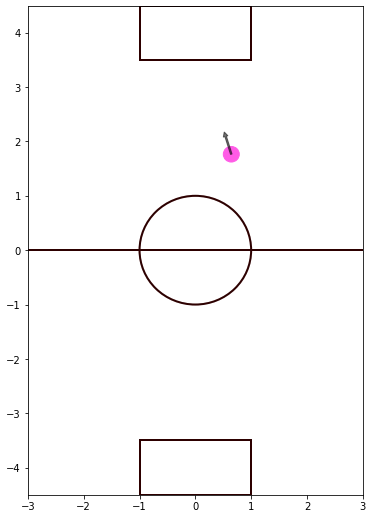

In [29]:
def visualization(loc, field, factor=7):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Alpha-beta, green for odometry, red for observations, purple for result')
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    landmarks = {
    "blue_posts": [
        [ -1.0, -4.5], [ 1.0, -4.5]
    ],
    "yellow_posts":[[ -1.0, 4.5], [1.0, 4.5]]}
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
    
    # odometry's location
    circle = plt.Circle((loc.odometry_y, loc.odometry_x), 1./factor, facecolor="green", edgecolor='green')
    plt.gca().add_patch(circle)
 
    # odometry's orientation
    arrow = plt.Arrow(loc.odometry_y, loc.odometry_x, 3*math.sin(loc.odometry_yaw)/factor, 
                      3*math.cos(loc.odometry_yaw)/factor, width=1.0/factor, alpha=0.5, 
                      facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)
    
    
    # location from observations
    circle = plt.Circle((loc.obs_coord[1], loc.obs_coord[0]), 1./factor, facecolor="red", edgecolor='red')
    plt.gca().add_patch(circle)
 
    # orientation from observations
    arrow = plt.Arrow(loc.obs_coord[1], loc.obs_coord[0], 3*math.sin(loc.obs_yaw)/factor, 
                      3*math.cos(loc.obs_yaw)/factor, width=1.0/factor, alpha=0.5, 
                      facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)
    
 
    # robot's location
    circle = plt.Circle((loc.myrobot.y, loc.myrobot.x), 1./factor, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(loc.myrobot.y, loc.myrobot.x, 3*math.sin(loc.myrobot.yaw)/factor, 
                      3*math.cos(loc.myrobot.yaw)/factor, 
                      width=1.0/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow) 
     
    #fixed landmarks of known locations2
   
    for lm in landmarks:
        for lms in landmarks[lm]:
            if lm == "yellow_posts":
                circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor, facecolor = '#ffff00', edgecolor='#330000')
                plt.gca().add_patch(circle)
            else:
                circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor, facecolor =  '#060C73', edgecolor='#330000')
                plt.gca().add_patch(circle)

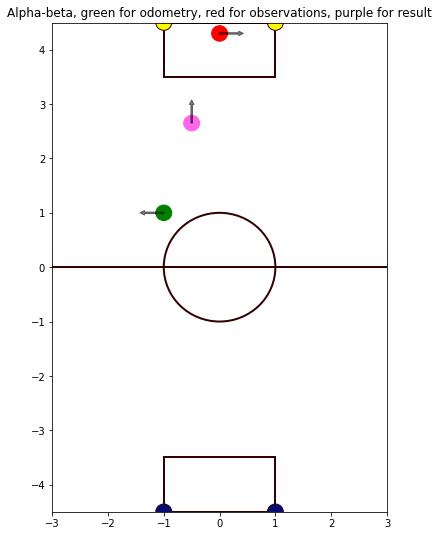

In [34]:
visualization(loc, Field("../localization/parfield.json"))